In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.test.gpu_device_name()

Num GPUs Available:  0


2022-05-17 18:29:39.540058: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


''

### Read the data

In [3]:
arxiv_data = pd.read_csv("./wiki.csv",index_col=0)
arxiv_data = arxiv_data.groupby("Title").filter(lambda x: len(x) == 1)
arxiv_data = arxiv_data[["Genre", "Plot"]]

In [4]:
arxiv_data

,Genre,Plot
Release Year,,
1901,unknown,"A bartender is working at a saloon, serving dr..."
1901,unknown,"The moon, painted with a smiling face hangs ov..."
1901,unknown,"The film, just over a minute long, is composed..."
1901,unknown,Lasting just 61 seconds and consisting of two ...
1903,western,The film opens with two bandits breaking into ...
...,...,...
2014,unknown,"The film begins in 1919, just after World War ..."
2017,comedy,"Two musicians, Salih and Gürkan, described the..."
2017,comedy,"Zafer, a sailor living with his mother Döndü i..."


### Get all possible tags from dataset

In [5]:
setTags = arxiv_data["Genre"].apply(lambda x: x.lstrip().replace(" & ", ", ").replace(" - ", ", ").replace(" / ", ", ").replace("-", ", ").replace(",", ", ").replace("/", ", ").replace("&", ", ").split(", ")).explode().unique()
setTags.sort()

setTags = list(map(lambda x: x.lstrip(), setTags))

decode = {}
encode = {}
decodeKeys = np.array(range(len(setTags)))
for i in range(len(setTags)):
    decode[i] = setTags[i]
    encode[setTags[i]] = i
ohe = tf.one_hot(decodeKeys, len(setTags))
decode

{0: '',
 1: '',
 2: '007',
 3: '1 girl',
 4: '3',
 5: '3 suitors',
 6: '3d',
 7: 'action',
 8: 'action comedy',
 9: 'adult',
 10: 'adult comedy',
 11: 'adventure',
 12: 'adventure drama',
 13: 'adventure science fantasy',
 14: 'age',
 15: 'age drama',
 16: 'ancient',
 17: 'animated',
 18: 'animation',
 19: 'anime',
 20: 'anthology',
 21: 'apocalyptic',
 22: 'apocalyptic science fiction',
 23: 'art film',
 24: 'art house',
 25: 'arts',
 26: 'asin',
 27: 'b.r films',
 28: 'biker',
 29: 'bio',
 30: 'biographical',
 31: 'biographical drama',
 32: 'biography',
 33: 'biopic',
 34: 'black comedy',
 35: 'buddy comedy',
 36: 'business',
 37: 'can ',
 38: 'chanbara',
 39: 'charmy kaur',
 40: 'chess)',
 41: 'children',
 42: "children's",
 43: "children's film",
 44: 'cinekorn entertainment',
 45: 'cinema',
 46: 'com',
 47: 'comedy',
 48: 'comedy ',
 49: 'comedy; 6 separate stories',
 50: 'costume',
 51: 'crime',
 52: 'crime drama',
 53: 'crime thriller',
 54: 'crime.',
 55: 'cult',
 56: 'cyberpun

### Create column genList2, which contains matrix representation for each movie

In [6]:
def decodeTags(lst, encode):
    out = np.array(list(map(lambda y: ohe[encode[y.lstrip()]] ,np.array(lst.lstrip().replace(" & ", ", ").replace(" - ", ", ").replace(" / ", ", ").replace("-", ", ").replace(",", ", ").replace("/", ", ").replace("&", ", ").split(", ")))))
    return out

ds2 = arxiv_data.dropna()[arxiv_data['Genre'] != "unknown"]
ds2 = ds2.assign(genList2= ds2.loc[:,"Genre"].apply(lambda x: np.sum(decodeTags(x, encode), axis=0)))
for i in range(len(setTags)):
    ds2[setTags[i]] = ds2["genList2"].map(lambda x: x[i])
arxiv_data = ds2

/var/folders/f1/kt7zkm5s0jl83qydm2tzz5180000gp/T/ipykernel_97327/4037472592.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ds2[setTags[i]] = ds2["genList2"].map(lambda x: x[i])
/var/folders/f1/kt7zkm5s0jl83qydm2tzz5180000gp/T/ipykernel_97327/4037472592.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ds2[setTags[i]] = ds2["genList2"].map(lambda x: x[i])
/var/folders/f1/kt7zkm5s0jl83qydm2tzz5180000gp/T/ipykernel_97327/4037472592.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calli

In [7]:
print(f"There are {len(arxiv_data)} rows in the dataset.")

There are 25118 rows in the dataset.


In [8]:
arxiv_data

,Genre,Plot,genList2,,007,1 girl,3,3 suitors,3d,action,...,yakuza,yakuza film,yash dasgupta,yash raj films,yogesh dattatraya gosavi's directorial debut. [9],youth drama,youth music drama,yuen lai,zombie comedy,zombie horror
Release Year,,,,,,,,,,,,,,,,,,,,,
1903,western,The film opens with two bandits breaking into ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1904,comedy,The film is about a family who move to the sub...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1906,short,The Rarebit Fiend gorges on Welsh rarebit at a...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1906,short action/crime western,The film features a train traveling through th...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1907,biographical,Boone's daughter befriends an Indian maiden as...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013,drama film,"Zeynep lost her job at weaving factory, and he...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017,comedy,"Two musicians, Salih and Gürkan, described the...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017,comedy,"Zafer, a sailor living with his mother Döndü i...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Getting top 10 tags out of all tags

In [9]:
nTop = 10
# first tag was deleted since it may be cause of thhe overfitting
topTags = arxiv_data.iloc[:,3:].sum().sort_values(ascending=False)[1:nTop+1]
indTopTags = list(map(lambda x: encode[x], topTags.index))
indTopTags.sort()

In [10]:
decode = {}
encode = {}
decodeKeys = np.array(range(len(topTags)))
for i in range(len(topTags)):
    decode[i] = topTags.index[i]
    encode[topTags.index[i]] = i

print(decode)
print(encode)
print(indTopTags)
topTags

{0: 'comedy', 1: 'action', 2: 'romance', 3: 'horror', 4: 'thriller', 5: 'western', 6: 'crime', 7: 'adventure', 8: 'musical', 9: 'family'}
{'comedy': 0, 'action': 1, 'romance': 2, 'horror': 3, 'thriller': 4, 'western': 5, 'crime': 6, 'adventure': 7, 'musical': 8, 'family': 9}
[259, 284, 402, 448, 543, 605, 667, 756, 922, 964]


comedy       5424.0
action       1802.0
romance      1536.0
horror       1221.0
thriller     1200.0
western       852.0
crime         821.0
adventure     660.0
musical       641.0
family        446.0
dtype: float32

### Now get rid of movies, which has not any genre from the top 10

In [11]:
dataSet = arxiv_data.iloc[:,:].drop(set(setTags) - set(topTags.index),axis=1)
dataSet["genList2"] = dataSet["genList2"].map(lambda x: np.take(x,indTopTags))
dataSet = dataSet[dataSet['genList2'].apply(lambda x: sum(list(map(lambda y: int(y), x)))) >= 1]
dataSet

,Genre,Plot,genList2,action,adventure,comedy,crime,family,horror,musical,romance,thriller,western
Release Year,,,,,,,,,,,,,
1903,western,The film opens with two bandits breaking into ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1904,comedy,The film is about a family who move to the sub...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1907,comedy,Before heading out to a baseball game at a nea...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1908,comedy,A young couple decides to elope after being ca...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1908,western,The film opens in a town on the Mexican border...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,comedy,"Şahin K. is a wealthy and famous (or, rather, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011,comedy-drama,"Abandoned with a son by her husband years ago,...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011,comedy-drama,"Zephyr is a strong-willed little girl, spendin...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Remove movies with short description and movies with not popular set of tags (it is needed for the stratification)

In [12]:
dataSet2 = dataSet.reset_index(drop=True, inplace=False)
dataSet2 = dataSet2[dataSet2['Plot'].apply(lambda x: len(str(x).split())) > 20]
z = dataSet2["genList2"].apply(lambda x: str(x)).value_counts(ascending=True) != 1
delLst = []

for i,k in zip(z.values, z.index):
    if not i:
        delLst.append(k)

dataSet2 = dataSet2[dataSet2['genList2'].apply(lambda x: str(x)).map(lambda x: x not in delLst)]
dataSet2

,Genre,Plot,genList2,action,adventure,comedy,crime,family,horror,musical,romance,thriller,western
0,western,The film opens with two bandits breaking into ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,comedy,The film is about a family who move to the sub...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,comedy,Before heading out to a baseball game at a nea...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,comedy,A young couple decides to elope after being ca...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,western,The film opens in a town on the Mexican border...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13051,comedy-drama,Emrah is a dreamer who hopes to be a great dir...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13052,comedy,"Şahin K. is a wealthy and famous (or, rather, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13053,comedy-drama,"Abandoned with a son by her husband years ago,...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13054,comedy-drama,"Zephyr is a strong-willed little girl, spendin...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import re
nlp = English()
def cleanPlot(qq):
    tokenizer = nlp.tokenizer(qq.lower())
    tokenizer = " ".join([str(x) if str(x) not in STOP_WORDS else "" for x in tokenizer])
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    no_punc = ""
    for char in tokenizer:
        if char not in punctuations:
            no_punc = no_punc + char
    WHITE_SPACE_PATTERN = re.compile(r' +')
    return re.sub(WHITE_SPACE_PATTERN, ' ', no_punc.strip())

dataSet2['Plot'] = dataSet2['Plot'].apply(lambda x:cleanPlot(x))
dataSet2

,Genre,Plot,genList2,action,adventure,comedy,crime,family,horror,musical,romance,thriller,western
0,western,film opens bandits breaking railroad telegraph...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,comedy,film family suburbs hoping quiet life things s...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,comedy,heading baseball game nearby ballpark sports f...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,comedy,young couple decides elope caught midst romant...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,western,film opens town mexican border poker game goin...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13051,comedy-drama,emrah dreamer hopes great director trying shoo...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13052,comedy,şahin k wealthy famous infamous man discontent...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13053,comedy-drama,abandoned son husband years ago signora enrica...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13054,comedy-drama,zephyr strong willed little girl spending summ...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Create train, test and validation dataframes

In [14]:
test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    dataSet2, test_size=test_split,
    stratify=dataSet2["genList2"].apply(lambda x: str(x)).values,
)

val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 11484
Number of rows in validation set: 638
Number of rows in test set: 638


### For optimisation, transform dataframes to dataset type

In [15]:
batch_size = 128
def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["genList2"].values)
    label_binarized = labels.numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["Plot"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [16]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

### Preview of data

In [17]:
def decoding(lst):
    out = []
    for k in range(len(lst)):
        if int(lst[k]) == 1:
            out.append(decode[k])
    return out

text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {decoding(label[0])}")
    print(" ")

Abstract: b'evening july 4 las vegas hank mechanic frannie travel agent break celebrating fifth anniversary insensitive yearning adventure excitement spend night idealized partners \xe2\x80\x94 hank goes leila nubile beautiful circus girl frannie goes ray dark handsome musician \r\n nights passion hank breaks tracks frannie lover apartment abducts refuses stay walks away saying time goodbye forever \r\n hank follows airport frannie leave dream trip bora bora hank sings prove willing romantic boards plane saying late hank distraught goes home burn clothes frannie returns realizing mistake'
Label(s): ['crime']
 
Abstract: b'vowing revenge fianc\xc3\xa9e abducted stagecoach ends dead chris denning randolph scott rides town coroner creek seeking man responsible \r\n hotel owner kate hardison marguerite chapman asks escort home abbie barbara read inebriated wife rich rancher younger miles george macready motives mistaken chris beaten younger men widow della sally eilers tells younger trying

### Import BERT preprocess and encoder

In [18]:
bert_preprocess = hub.KerasLayer("http://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
bert_encoder = hub.KerasLayer("http://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", name='BERT_encoder')

In [19]:
def embed(smth):
    return bert_encoder(bert_preprocess(smth))['pooled_output']

### function to create a model

In [20]:
def makeModel():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer =  bert_preprocess(text_input)
    outputs  =  bert_encoder(preprocessing_layer)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(512, activation="relu")(net)
    net = tf.keras.layers.Dropout(0.20)(net)
    net = tf.keras.layers.Dense(256, activation="relu")(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(len(topTags), activation="sigmoid")(net)
    return tf.keras.Model(text_input, net)

In [21]:
nlpModel = makeModel()
nlpModel.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)
nlpModel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

### Training

Epoch 1/20
90/90 [==============================] - 321s 3s/step - loss: 0.3157 - categorical_accuracy: 0.3937 - val_loss: 0.2814 - val_categorical_accuracy: 0.4279
Epoch 2/20
90/90 [==============================] - 271s 3s/step - loss: 0.2746 - categorical_accuracy: 0.4511 - val_loss: 0.2629 - val_categorical_accuracy: 0.4796
Epoch 3/20
90/90 [==============================] - 266s 3s/step - loss: 0.2577 - categorical_accuracy: 0.4861 - val_loss: 0.2490 - val_categorical_accuracy: 0.5047
Epoch 4/20
90/90 [==============================] - 283s 3s/step - loss: 0.2466 - categorical_accuracy: 0.5083 - val_loss: 0.2422 - val_categorical_accuracy: 0.5204
Epoch 5/20
90/90 [==============================] - 265s 3s/step - loss: 0.2411 - categorical_accuracy: 0.5195 - val_loss: 0.2287 - val_categorical_accuracy: 0.5455
Epoch 6/20
90/90 [==============================] - 280s 3s/step - loss: 0.2375 - categorical_accuracy: 0.5302 - val_loss: 0.2245 - val_categorical_accuracy: 0.5517
Epoch 7/20

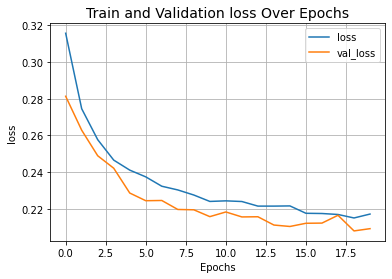

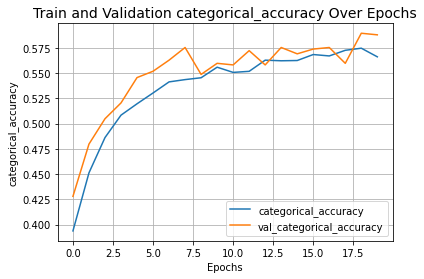

In [49]:
epochs = 15
log = nlpModel.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)

def plot_result(item):
    plt.plot(log.history[item], label=item)
    plt.plot(log.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title(f"Train and Validation {str(item)} Over Epochs", fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

In [50]:
#save model plz
#nlpModel.save("./Models/workPlzModel1model3")

INFO:tensorflow:Assets written to: ./Models/workPlzModel1model3\assets


INFO:tensorflow:Assets written to: ./Models/workPlzModel1model3\assets


### Test accuracy

In [51]:
_, categorical_acc = nlpModel.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

5/5 [==============================] - 13s 3s/step - loss: 0.2178 - categorical_accuracy: 0.5815
Categorical accuracy on the test set: 58.15%.


In [52]:
model_for_inference = nlpModel

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {decoding(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [x for _, x in sorted(
        zip(predicted_probabilities[i], topTags.index),
        key=lambda pair: pair[0],
        reverse=True,
    )][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

Abstract: b'In 1936, Doc Savage (Ron Ely) returns to New York City following a visit to his Arctic hideaway, the Fortess of Solitude. He learns that his father has died under mysterious circumstances while exploring the remote interior of the Central American Republic of Hidalgo. While examining his father\'s personal papers, Doc finds himself the target of an assassination attempt. Doc Savage chases and corners the sniper on the nearby Eastern Cranmoor Building, but the would-be assassin loses his footing and falls to his death. Examining the body, Doc discovers that his assailant is a Native American with peculiar markings; his fingertips are red, as if dipped in blood, while his chest bears an elaborate tattoo of the ancient Mayan god Kukulkan. Returning to his penthouse headquarters, Doc finds that intruders have destroyed his father\'s personal papers. Vowing to solve his father\'s murder, Doc Savage flies to Hidalgo with "The Fabulous Five", his brain trust, at his side.\r\nWaiti